Process 5 way breakdown

In [2]:
import os, sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import torch
from scipy import stats
import sklearn
from sklearn import inspection

sys.path.insert(0, 'src')
from utils.utils import read_lists, load_image, ensure_dir, write_lists, informal_log
from utils.visualizations import plot, show_image_rows, make_grid, bar_graph
from utils.df_utils import convert_string_columns, string_to_numpy, string_to_list
from utils.attribute_utils import hyperparam_search
from utils.metric_utils import sort_and_bin_df, calculate_bin_agreement, plot_alignment, run_feature_importance_trial, correlated_variables, print_summary, filter_df, string_to_list, plot_metric_v_inputs, get_coefficient_significance
import model.metric as module_metric


# Setup

In [70]:
# Make separate CSVs from master CSV
master_csv_path = 'saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/pixel_explainer.csv'
df = pd.read_csv(master_csv_path)
string_column_templates = ['{}_probabilities', '{}_outputs']
agents = ['human', 'model', 'explainer']
string_columns = []
for agent in agents:
    for template in string_column_templates:
        string_columns.append(template.format(agent))
df = convert_string_columns(
    df=df,
    columns=string_columns)
print("Read master CSV from {}".format(master_csv_path))
      
groups_save_dir = os.path.join(os.path.dirname(master_csv_path), 'group_csvs')
ensure_dir(groups_save_dir)

# Check if filenames are in the save directory
n_groups = 5
filenames = ['group_{}.csv'.format(i) for i in range(1, 6)]
dir_contents = os.listdir(groups_save_dir)
dir_empty = True
for file in filenames:
    if file in dir_contents:
        dir_empty = False
if False: #not dir_empty:
    print("Directory {} is not empty. Remove contents to save group CSVs".format(groups_save_dir))
else:
    dfs = []
    # Case 1: model = explainer = human 
    df1 = df[(df['model_predictions'] == df['explainer_predictions']) & (df['model_predictions'] == df['human_predictions'])]
    dfs.append(df1)
    # Case 2: model = explainer != human
    df2 = df[(df['model_predictions'] == df['explainer_predictions']) & (df['model_predictions'] != df['human_predictions'])]
    dfs.append(df2)

    # Case 3: model = human != explainer
    df3 = df[(df['model_predictions'] == df['human_predictions']) & (df['model_predictions'] != df['explainer_predictions'])]
    dfs.append(df3)

    # Case 4: explainer = human != model
    df4 = df[(df['explainer_predictions'] == df['human_predictions']) & (df['model_predictions'] != df['explainer_predictions'])]
    dfs.append(df4)

    # Case 5: explainer != model != human
    df5 = df[(df['explainer_predictions'] != df['human_predictions']) & (df['model_predictions'] != df['explainer_predictions']) & (df['model_predictions'] != df['human_predictions'])]
    dfs.append(df5)

    # Check that no rows overlap, all mutually exclusive
    for i in range(len(dfs) - 1):
        for j in range(i+1, len(dfs)):
            overlap = set(dfs[i].index) & set(dfs[j].index)
            assert len(overlap) == 0
    for idx, cur_df in enumerate(dfs):
        cur_csv_save_path = os.path.join(groups_save_dir, 'group_{}.csv'.format(idx+1))
        cur_df.to_csv(cur_csv_save_path)
        print("Saved CSV for group {} to {}".format(idx+1, cur_csv_save_path))

Read master CSV from saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/pixel_explainer.csv
Saved CSV for group 1 to saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/group_csvs/group_1.csv
Saved CSV for group 2 to saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/group_csvs/group_2.csv
Saved CSV for group 3 to saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/group_csvs/group_3.csv
Saved CSV for group 4 to saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/group_csvs/group_4.csv
Saved CSV for group 5 to saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_1

#### Join dataframes together, Make save directories

In [4]:
# group_nums = [1, 3]  # model and human are aligned
group_nums = [2, 4, 5]

cur_df_list = []
for group_num in group_nums:
    csv_path = os.path.join(groups_save_dir, 'group_{}.csv'.format(group_num))
    cur_df_list.append(pd.read_csv(csv_path))
    cur_df = pd.concat(cur_df_list)

print("Joined groups {} to form dataframe with {} rows".format(group_nums, len(cur_df)))

# Make directory for this grouping
group_name = 'group'
for i in group_nums:
    group_name += '_{}'.format(i)
cur_group_save_dir = os.path.join(groups_save_dir, group_name)
ensure_dir(cur_group_save_dir)
print("Created directory for groups {} at {}".format(group_nums, cur_group_save_dir))
graph_save_dir = os.path.join(cur_group_save_dir, 'graphs')
ensure_dir(graph_save_dir)
print("Created directory for graphs at {}".format(group_nums, cur_group_save_dir))

# Save current dataframe
cur_csv_save_path = os.path.join(cur_group_save_dir, '{}.csv'.format(group_name))
if not os.path.exists(cur_csv_save_path):
    cur_df.to_csv(cur_csv_save_path)
    print("Saved csv for groups {} at {}".format(group_nums, cur_csv_save_path))
else:
    print("CSV at {} already exists.".format(cur_csv_save_path))

Joined groups [2, 4, 5] to form dataframe with 709 rows
Created directory for groups [2, 4, 5] at saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/group_csvs/group_2_4_5
Created directory for graphs at [2, 4, 5]
CSV at saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/group_csvs/group_2_4_5/group_2_4_5.csv already exists.


# Process

#### Sensitivity study of n_bins on Pearsons for individual groups in current breakdown

['case1', 'case3']
n_bins: [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


<Figure size 432x288 with 0 Axes>

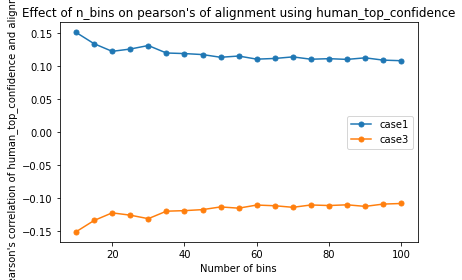

<Figure size 432x288 with 0 Axes>

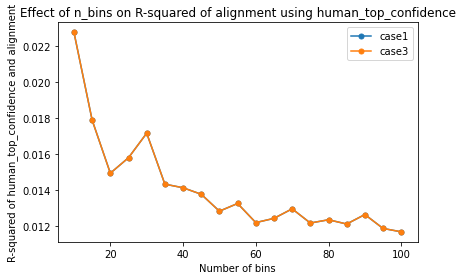

['case1', 'case3']
n_bins: [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


<Figure size 432x288 with 0 Axes>

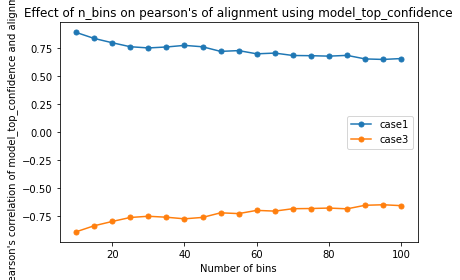

<Figure size 432x288 with 0 Axes>

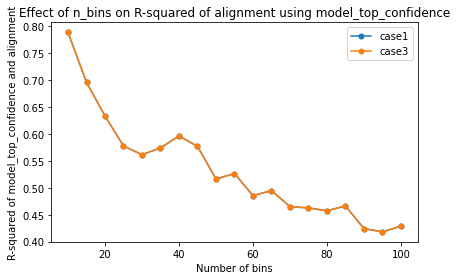

['case1', 'case3']
n_bins: [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


<Figure size 432x288 with 0 Axes>

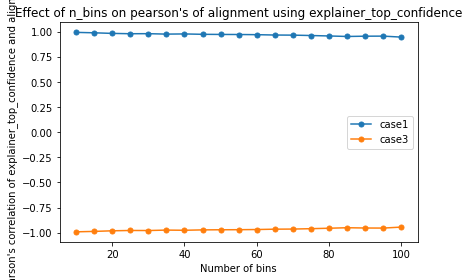

<Figure size 432x288 with 0 Axes>

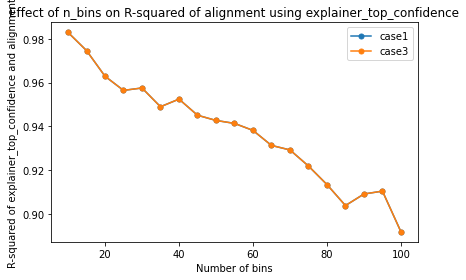

In [8]:
sensitivity_graph_save_dir = os.path.join(graph_save_dir, 'n_bin_sensitivity')
ensure_dir(sensitivity_graph_save_dir)
for iv_agent in ['human', 'model', 'explainer']:
    iv_names = ['{}_top_confidence'.format(iv_agent),
                '{}_t2c'.format(iv_agent),
                '{}_entropy'.format(iv_agent)]
    # agent_pairs = [
    #     ('human', 'explainer'),
    #     ('human', 'model'),
    #     ('model', 'explainer')]
    cases = ['case{}'.format(i) for i in group_nums]
    print(cases)
    
    all_pearsons = []
    all_r_squared = []
    n_bins = [i for i in range(10, 101, 5)]
    print("n_bins: {}".format(n_bins))

    for case_idx, case in enumerate(cases):
        # agent1, agent2 = pair
        cur_pearsons = []
        cur_r_squared = []
        for n_bin in n_bins:
            bin_rows, iv_means, iv_stds, iv_ses = sort_and_bin_df(
                df=cur_df,
                sort_columns=iv_names, 
                n_bins=n_bin)
            cur_agreements, agreement_stds, agreement_ses = calculate_bin_agreement(
                bin_rows=bin_rows,
                column_name=case)
            pearsons = stats.pearsonr(iv_means, cur_agreements).statistic
            cur_pearsons.append(pearsons)
            # slope, yint, r, p, std_err = stats.linregress(iv_means, cur_agreement)
            r_squared = pearsons ** 2
            cur_r_squared.append(r_squared)
        all_pearsons.append(cur_pearsons)
        all_r_squared.append(cur_r_squared)

    # Plot pearsons v n_bins
    plot(
        xs=[n_bins for i in range(len(cases))],
        ys=all_pearsons,
        labels=cases,
        xlabel='Number of bins',
        ylabel="Pearson's correlation of {} and alignment".format(iv_names[0]),
        title='Effect of n_bins on pearson\'s of alignment using {}'.format(
            iv_names[0]),
        show=True,
        save_path=os.path.join(sensitivity_graph_save_dir, 'nbins_pearsons_{}.png'.format(iv_names[0])))


    # Plot r-squared v n_bins
    plot(
        xs=[n_bins for i in range(len(cases))],
        ys=all_r_squared,
        labels=cases,
        xlabel='Number of bins',
        ylabel="R-squared of {} and alignment".format(iv_names[0]),
        title='Effect of n_bins on R-squared of alignment using {}'.format(
            iv_names[0]),
        show=True,
        save_path=os.path.join(sensitivity_graph_save_dir, 'nbins_rsquared_{}.png'.format(iv_names[0])))

#### Let's just look at groups 1,3 in the 5 way breakdown

##### Linear Regression

Figure saved to saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/group_csvs/group_1_3/graphs/human-explainer_alignment_v_t2c.png


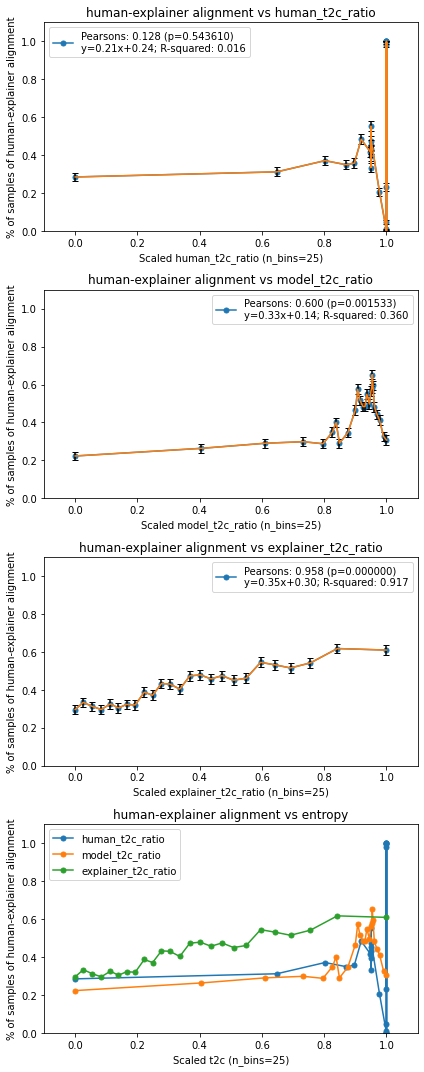

Figure saved to saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/group_csvs/group_1_3/graphs/model-explainer_alignment_v_t2c.png


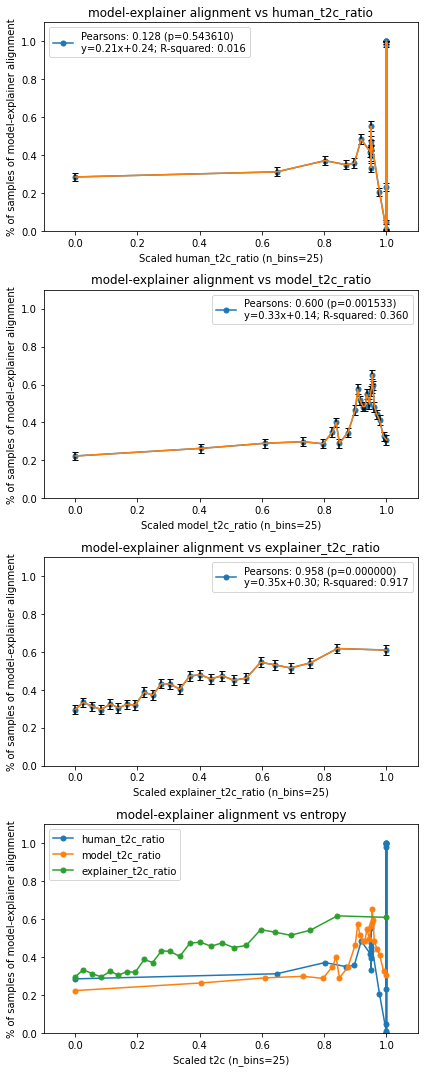

Pearsons between variance of confusion and variance of alignment: 0.092 (p=0.262501)
y=0.02x+0.02; R-squared: 0.008


In [18]:
agent_pairs = [
    ('human', 'explainer'),
    # ('human', 'model'),
    ('model', 'explainer')
]
agents = ['human', 'model', 'explainer']

plot_xerr = False
plot_yerr = True

# confusion_templates = ['{}_entropy', '{}_t2c']
# confusion_templates = ['{}_t2c', '{}_entropy']
confusion_templates = ['{}_t2c_ratio']
# confusion_templates = ['{}_top_confidence', '{}_t2c', '{}_entropy']
x_variance = []
y_variance = []
if 'entropy' in confusion_templates[0]:
    n_bins = 20
elif 't2c' in confusion_templates[0]:
    n_bins = 25
elif 'top_confidence' in confusion_templates[0]:
    n_bins = 25
else:
    raise ValueError("Confusion type in '{}' not supported.".format(confusion_templates[0]))
for agent_pair in agent_pairs:
    agent1, agent2 = agent_pair
    confusions = []
    agreements = []
    fig, axs = plt.subplots(4, 1, figsize=(6, 15))
    
    # Separate plot for confusion from each agent
    for idx, agent in enumerate(agents):
        confusion_names = [confusion_template.format(agent) for confusion_template in confusion_templates]
        ax, iv_means, iv_stds, cur_agreement, agreement_ses, ylabel = plot_alignment(
            df=cur_df,
            confusion_names=confusion_names,
            n_bins=n_bins,
            fig=fig,
            ax=axs[idx],
            alignment_col_name=None,
            agent1=agent1,
            agent2=agent2,
            plot_xerr=plot_xerr,
            plot_yerr=plot_yerr)

        confusions.append(iv_means)
        agreements.append(cur_agreement)

        x_variance.append(iv_stds)
        y_variance.append(agreement_ses)
        axs[idx] = ax
    
    xlabel = 'Scaled {} (n_bins={})'.format(confusion_templates[0].split('_')[1], n_bins)
    title = '{}-{} alignment vs entropy'.format(agent1, agent2)
    fig, ax = plot(
        xs=confusions,
        ys=agreements,
        fig=fig,
        ax=axs[-1],
        labels=[confusion_templates[0].format(agent) for agent in agents],
        xlabel=xlabel,
        ylabel=ylabel,
        ylimits=[0, 1.1],
        xlimits=[-0.1, 1.1],
        title=title,
        show=False)
    axs[-1] = ax
    save_path = os.path.join(graph_save_dir, '{}-{}_alignment_v_{}.png'.format(agent1, agent2, confusion_templates[0].split('_')[1]))
    plt.savefig(save_path)
    print("Figure saved to {}".format(save_path))
    plt.show()
    
x_variance = np.concatenate(x_variance, axis=0)
y_variance = np.concatenate(y_variance, axis=0)

slope, yint, r, p, std_err = stats.linregress(
    x=x_variance,
    y=y_variance)
print('Pearsons between variance of confusion and variance of alignment: {:.3f} (p={:.6f})\ny={:.2f}x+{:.2f}; R-squared: {:.3f}'.format(
        r, p, slope, yint, r**2))


#### Logistic Regression Classifiers

In [20]:
# Set constants
seed = 1
penalty = 'l2'
solver = 'lbfgs'
class_weight = 'balanced'
logistic_regression_args = {
    'penalty': penalty,
    'solver': solver,
    'class_weight': class_weight
}

metric_names = ['accuracy', 'precision', 'recall', 'f1', 'neg_log_loss']

# Split dataframe into train/test
train_split = 0.7
# shuffled = cur_df.sample(frac=1, random_state=seed)
train_rows = cur_df.sample(frac=train_split, random_state=seed)
print(train_rows['case1'][:5])
val_rows = cur_df.drop(train_rows.index)
assert len(set(train_rows.index).intersection(set(val_rows.index))) == 0

# Create x, y data
iv_types = ['top_confidence', 'entropy', 't2c']
agents = ['human', 'model', 'explainer']
agent_pairs = [
    ('human', 'explainer'),
    # ('model', 'explainer'),
    # ('human', 'model')
]

agents_list = [
    ['human'],
    ['model'],
    ['explainer'],
    ['human', 'explainer'],
    ['human', 'model'],
    ['model', 'explainer'],
    ['human', 'explainer', 'model']
]

for agent1, agent2 in agent_pairs:
    print("{}-{} alignment in training: {:.2f} \t in test: {:.2f}".format(
        agent1, agent2,
        100 * len(train_rows[train_rows['{}_{}_alignment'.format(agent1, agent2)] == 1]) / len(train_rows),
        100 * len(val_rows[val_rows['{}_{}_alignment'.format(agent1, agent2)] == 1]) / len(val_rows)))
        

3812    False
3402    False
3463     True
2874    False
1887    False
Name: case1, dtype: bool
human-explainer alignment in training: 42.67 	 in test: 31.81


In [21]:
# List to store results from all trials
trials = []
clfs = []
trial_keys = []
trial_idx = 1
n_trials = len(iv_types) * len(agents_list) * len(agent_pairs)
for iv_type in iv_types:
    for idx, agents in enumerate(agents_list):
        x_names = ['{}_{}'.format(agent, iv_type) for agent in agents]
        for x_name in x_names:
            assert x_name in cur_df.columns 
        
        for agent1, agent2 in agent_pairs:
            # set seed 
            seed = 0
            y_names = ['{}_{}_alignment'.format(agent1, agent2)]
            print("Itr {}/{}: IV: {} DV: {}".format(trial_idx, n_trials, x_names, y_names))
            trial_return = run_feature_importance_trial(
                train_rows=train_rows,
                val_rows=val_rows,
                x_names=x_names,
                y_names=y_names,
                metric_names=metric_names,
                trial_id=trial_idx-1,
                logistic_regression_args=logistic_regression_args,
                seed=seed)
            clf = trial_return['clf']
            cur_data = trial_return['cur_data']
            trial_key = trial_return['trial_key']
            
            clfs.append(clf)
            trials.append(cur_data)
            trial_keys.append(trial_key)
            trial_idx += 1


Itr 1/21: IV: ['human_top_confidence'] DV: ['human_explainer_alignment']
Best accuracy: 0.4572687224669604 Regularization: 0.001
Best accuracy: 0.46079295154185024 Regularization: 0.1
Learned classifier to predict ['human_explainer_alignment'] from ['human_top_confidence']
Coefficients: [[1.0795193]]
Predictions:
0: 31.01
1: 68.99
Itr 2/21: IV: ['model_top_confidence'] DV: ['human_explainer_alignment']
Best accuracy: 0.42466960352422906 Regularization: 0.001
Learned classifier to predict ['human_explainer_alignment'] from ['model_top_confidence']
Coefficients: [[0.04026519]]
Predictions:
0: 15.42
1: 84.58
Itr 3/21: IV: ['explainer_top_confidence'] DV: ['human_explainer_alignment']
Best accuracy: 0.6563876651982379 Regularization: 0.001
Best accuracy: 0.6581497797356828 Regularization: 0.05
Learned classifier to predict ['human_explainer_alignment'] from ['explainer_top_confidence']
Coefficients: [[2.74755051]]
Predictions:
0: 63.26
1: 36.74
Itr 4/21: IV: ['human_top_confidence', 'expla

In [22]:
# Create save directory
logreg_save_dir = os.path.join(cur_group_save_dir, 'logreg_results')
ensure_dir(logreg_save_dir)

# Save feature importance results in different forms
logreg_df = pd.DataFrame(trials)
logreg_df_path = os.path.join(logreg_save_dir, 'sensitivity.csv')
logreg_df.to_csv(logreg_df_path)
print("Saved sensitivity results to {}".format(logreg_df_path))

# Write map of trial idx to iv/dv combination
trial_keys_path = os.path.join(logreg_save_dir, 'trial_keys.txt')
write_lists(trial_keys, trial_keys_path)

# Save logistic regression arguments
logreg_args_save_path = os.path.join(logreg_save_dir, 'logreg_args.json')
with open(logreg_args_save_path, 'w') as f:
    json.dump(logistic_regression_args, f)
print("Saved logistic regression arguments to {}".format(logreg_args_save_path))

Saved sensitivity results to saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/group_csvs/group_1_3/logreg_results/sensitivity.csv
Saved logistic regression arguments to saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/group_csvs/group_1_3/logreg_results/logreg_args.json


In [23]:
# Obtain correlated pairs 
all_x_names = [
    'human_top_confidence', 'model_top_confidence', 'explainer_top_confidence', 
    'human_entropy', 'model_entropy', 'explainer_entropy', 
    'human_t2c', 'model_t2c', 'explainer_t2c'
]
low_corr_set, med_corr_set, high_corr_set = correlated_variables(
    train_rows=train_rows,
    x_names=all_x_names)

Low correlation pairs (<0.3)
('human_top_confidence', 'model_top_confidence', 0.15512483505595925, 2.5777196529566818e-36)
('human_top_confidence', 'explainer_top_confidence', 0.09973511030884263, 7.509529931392739e-16)
('human_top_confidence', 'model_entropy', -0.15298717926028457, 2.3427101920872167e-35)
('human_top_confidence', 'explainer_entropy', -0.09401938278236939, 3.0122197129894977e-14)
('human_top_confidence', 'model_t2c', -0.16952396350085286, 3.926677198365656e-43)
('human_top_confidence', 'explainer_t2c', -0.06854201867686902, 3.144772676806348e-08)
('model_top_confidence', 'explainer_top_confidence', 0.10006647949860527, 6.022718555814908e-16)
('model_top_confidence', 'human_entropy', -0.1538501600617304, 9.647911867839761e-36)
('model_top_confidence', 'explainer_entropy', -0.10315562110489816, 7.43612305844052e-17)
('model_top_confidence', 'human_t2c', -0.1553463238229656, 2.047087026246919e-36)
('model_top_confidence', 'explainer_t2c', -0.053860523014153054, 1.38623724

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(human_t2c, explainer_t2c) has low correlation
(human_t2c, model_t2c) has low correlation
(model_t2c, explainer_t2c) has low correlation
Highest accuracy with ['explainer_t2c']: 0.6881


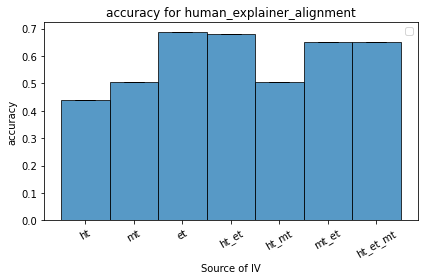

Row index 14
IV: ['human_t2c'] 
DV: ['human_explainer_alignment']
Metrics
	accuracy: 0.4396
		 'human_t2c' sensitivity: 0.0329
	f1: 0.4374
		 'human_t2c' sensitivity: 0.0277
Row index 15
IV: ['model_t2c'] 
DV: ['human_explainer_alignment']
Metrics
	accuracy: 0.5057
		 'model_t2c' sensitivity: 0.0617
	f1: 0.5057
		 'model_t2c' sensitivity: 0.0551
Row index 16
IV: ['explainer_t2c'] 
DV: ['human_explainer_alignment']
Metrics
	accuracy: 0.6881
		 'explainer_t2c' sensitivity: 0.1215
	f1: 0.6461
		 'explainer_t2c' sensitivity: 0.1534
Row index 17
IV: ['human_t2c', 'explainer_t2c'] 
DV: ['human_explainer_alignment']
Metrics
	accuracy: 0.6784
		 'human_t2c' sensitivity: 0.0087
		 'explainer_t2c' sensitivity: 0.1196
	f1: 0.6388
		 'human_t2c' sensitivity: 0.0107
		 'explainer_t2c' sensitivity: 0.1496
Row index 18
IV: ['human_t2c', 'model_t2c'] 
DV: ['human_explainer_alignment']
Metrics
	accuracy: 0.5048
		 'human_t2c' sensitivity: 0.0057
		 'model_t2c' sensitivity: 0.0458
	f1: 0.5047
		 'human_

In [26]:
logreg_df_path = os.path.join(cur_group_save_dir, 'logreg_results', 'sensitivity.csv')
# logreg_df_path = 'saved/ADE20K/survey_results/group_1_3/logreg_results/sensitivity.csv'
logreg_df = pd.read_csv(logreg_df_path)
ivs = ['t2c']
dv = 'human_explainer_alignment'
metrics = ['accuracy', 'f1']
drop_correlated = True

cur_logreg_df = filter_df(logreg_df,
    ivs=ivs,
    dv=dv)

# Drop rows that have correlated variables
if drop_correlated:
    drop_idxs = []
    for idx, row in cur_logreg_df.iterrows():
        row_ivs = string_to_list(row['iv'], dtype='string')
        row_ivs = [word.replace("'", "") for word in row_ivs]
        
        # if len(row_ivs) > 2:
        #     drop_idxs.append(row['Unnamed: 0'])
        if len(row_ivs) == 2:
            var1, var2 = row_ivs
            if (var1, var2) in low_corr_set or (var2, var1) in low_corr_set:
                print("({}, {}) has low correlation".format(var1, var2))
            elif (var1, var2) in med_corr_set or (var2, var1) in med_corr_set:
                print("({}, {}) has moderate correlation".format(var1, var2))
            else:
                drop_idxs.append(row['Unnamed: 0'])
                print("Dropping ({}, {})".format(var1, var2))
    cur_logreg_df = cur_logreg_df.drop(drop_idxs, axis=0)

log_path = 'temp/temp.txt'
highest_acc_row = cur_logreg_df.loc[cur_logreg_df['accuracy'].idxmax()]
print("Highest accuracy with {}: {:.4f}".format(
    highest_acc_row['iv'],
    highest_acc_row['accuracy']))

plot_metric_v_inputs(
    df=cur_logreg_df,
    ivs=ivs,
    dv=dv,
    graph_metric='accuracy')
print_summary(
    df=cur_logreg_df,
    metrics=metrics,
    log_path=log_path)

#### Logistic Regression for predicting 2, 4, and 5

In [37]:
# Start with just groups 2,4,5
cur_df_path = 'saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/group_csvs/group_2_4_5/group_2_4_5.csv'
cur_df = pd.read_csv(cur_df_path)
cur_group_save_dir = os.path.dirname(cur_df_path)

one_hot_labels = cur_df[['case2', 'case4', 'case5']].to_numpy()
for row in one_hot_labels:
    assert np.sum(row) == 1
labels = np.argmax(one_hot_labels, axis=1)
'''
0 -> 2
1 -> 4
2 -> 5
'''
cur_df['labels'] = labels

unique_labels, unique_counts = np.unique(labels, return_counts=True)
for l, c in zip(unique_labels, unique_counts):
    print("Label {} has {} occurrences".format(l, c))

Label 0 has 166 occurrences
Label 1 has 137 occurrences
Label 2 has 406 occurrences


In [53]:
# Set constants
seed = 1
penalty = 'l2'
solver = 'lbfgs'
class_weight = 'balanced'
multi_class = 'ovr'
logistic_regression_args = {
    'penalty': penalty,
    'solver': solver,
    'class_weight': class_weight,
    'multi_class': multi_class
}

metric_names = ['accuracy', 'precision', 'recall', 'f1'] #, 'neg_log_loss']

# Split dataframe into train/test
train_split = 0.7
train_rows = cur_df.sample(frac=train_split, random_state=seed)
print(train_rows['labels'][:5])
val_rows = cur_df.drop(train_rows.index)
assert len(set(train_rows.index).intersection(set(val_rows.index))) == 0

for split_name, rows in [('train', train_rows), ('test', val_rows)]:
    unique_labels, unique_counts = np.unique(rows['labels'], return_counts=True)
    for l, c in zip(unique_labels, unique_counts):
        print("[{}] Label {} has {} occurrences".format(split_name, l, c))
# Create x, y data
iv_types = ['top_confidence', 'entropy', 't2c']
agents = ['human', 'model', 'explainer']


agents_list = [
    ['human'],
    ['model'],
    ['explainer'],
    ['human', 'explainer'],
    ['human', 'model'],
    ['model', 'explainer'],
    ['human', 'explainer', 'model']
]


189    1
111    0
551    2
429    2
666    2
Name: labels, dtype: int64
[train] Label 0 has 123 occurrences
[train] Label 1 has 91 occurrences
[train] Label 2 has 282 occurrences
[test] Label 0 has 43 occurrences
[test] Label 1 has 46 occurrences
[test] Label 2 has 124 occurrences


In [94]:
def multiclass_run_feature_importance_trial(train_rows,
                                 val_rows,
                                 x_names,
                                 y_names,
                                 metric_names,
                                 trial_id,
                                 logistic_regression_args,
                                 seed):
    # Get metric fns from names
    metric_fns = [getattr(module_metric, metric_name) for metric_name in metric_names]

    # Create structure for storing trial run
    cur_data = {}
    
    # Obtain x, y data
    train_x = train_rows[x_names].to_numpy()
    train_y = np.squeeze(train_rows[y_names].to_numpy())
    assert len(train_x) == len(train_y)
    val_x = val_rows[x_names].to_numpy()
    val_y = np.squeeze(val_rows[y_names].to_numpy())
    assert len(val_x) == len(val_y)

    # add iv, dv to data
    cur_data['iv'] = x_names
    cur_data['dv'] = y_names
    trial_key = "{} {}".format(trial_id, str((x_names, y_names)))

    # Scale the features to be between [0, 1]
    scaler = sklearn.preprocessing.MinMaxScaler()
    scaler.fit(train_x)
    train_x = scaler.transform(train_x)
    val_x = scaler.transform(val_x)

    # Perform hyperparameter search on classifier
    clf = hyperparam_search(
        train_features=train_x,
        train_labels=train_y,
        val_features=val_x,
        val_labels=val_y,
        scaler=None,
        logistic_regression_args=logistic_regression_args)

    print("Learned classifier to predict {} from {}".format(y_names, x_names))
    print("Coefficients: {}".format(clf.coef_))
    # Obtain predictions on validation set
    val_predictions = clf.predict(val_x)
    
    # Print count of unique predictions
    unique, unique_counts = np.unique(val_predictions, return_counts=True)
    print("Predictions:")
    for val, count in zip(unique, unique_counts):
        print("{}: {:.2f}".format(val, 100 * count / len(val_predictions)))
    # Calculate metrics
    metrics = module_metric.compute_metrics(
        metric_fns=metric_fns,
        prediction=val_predictions.ravel(),
        target=val_y.ravel(),
        save_mean=True)
    for metric_name in metric_names:
        if '{}_mean'.format(metric_name) in metrics:
            cur_data[metric_name] = metrics['{}_mean'.format(metric_name)]
            cur_data['{}_per_class'.format(metric_name)] = metrics[metric_name]
        elif metric_name in metrics:
            cur_data[metric_name] = metrics[metric_name]

    # For multi class case, modify metric names to include averaging method
    importance_metric_names = []
    need_average = set(['precision', 'recall', 'f1'])
    for metric in metric_names:
        if metric in need_average:
            importance_metric_names.append('{}_weighted'.format(metric))
        else:
            importance_metric_names.append(metric)
            # Calculate variable sensitivity to each metric
    importance_results = inspection.permutation_importance(
        estimator=clf,
        X=train_x,
        y=train_y.ravel(),
        scoring=importance_metric_names,
        random_state=seed,
        n_repeats=50)
    for metric_name, cur_importance_results in importance_results.items():
        if 'weighted' in metric_name:
            metric_name = metric_name.split('_weighted')[0]
        cur_data['{}_sensitivity_mean'.format(metric_name)] = cur_importance_results['importances_mean'].tolist()
        cur_data['{}_sensitivity_std'.format(metric_name)] = cur_importance_results['importances_std'].tolist()
    
    # Calculate coefficient importance 
    coefficient_t, coefficient_p = get_coefficient_significance(
        X=train_x,
        y=train_y.ravel(),
        classifier=clf)
    cur_data['coefficient_t'] = coefficient_t.tolist()[0]
    cur_data['coefficient_p'] = coefficient_p.tolist()[0]
    
    return {
        'clf': clf,
        'cur_data': cur_data, 
        'trial_key': trial_key
    }


def print_summary(df, 
                  metrics=['accuracy', 'precision', 'recall', 'f1', 'neg_log_loss'],
                  graph_metric=None,
                  print_coefficient_importance=False,
                  log_path=None):
    sensitivity_metrics = ['{}_sensitivity_mean'.format(metric) for metric in metrics]

    for idx, row in df.iterrows():
        informal_log("Row index {}".format(idx), log_path)
        informal_log("IV: {} \nDV: {}".format(row['iv'], row['dv']), log_path)
        informal_log("Metrics", log_path)
        ivs = string_to_list(row['iv'])
        
        # Print metrics and the variable sensitivity
        for metric in metrics:
            
            try: 
                informal_log("\t{}: {:.4f}".format(metric, row[metric]), log_path)
                metric_sensitivities = string_to_list(
                    row['{}_sensitivity_mean'.format(metric)],
                    dtype='float')
                for iv, metric_sensitivity in zip(ivs, metric_sensitivities):
                    informal_log("\t\t {} sensitivity: {:.4f}".format(iv, metric_sensitivity), log_path)
            except:
                informal_log("\t{}: {}".format(metric, row[metric]), log_path)
                continue
        # Print coefficient importance scores and p-values
        if print_coefficient_importance:
            informal_log("Coefficient significance:", log_path)
            coefficient_ts = string_to_list(row['coefficient_t'], dtype='float')
            coefficient_ps = string_to_list(row['coefficient_p'], dtype='float')
            for idx, iv in enumerate(ivs):
                coefficient_t = coefficient_ts[idx]
                coefficient_p = coefficient_ps[idx]

                informal_log("\t{} t: {:.4f} p-value: {:.4f}".format(iv, coefficient_t, coefficient_p), log_path)

In [89]:
# List to store results from all trials
trials = []
clfs = []
trial_keys = []
trial_idx = 1
n_trials = len(iv_types) * len(agents_list) * 1 #len(agent_pairs)
y_names = ['labels']
for iv_type in iv_types:
    for idx, agents in enumerate(agents_list):
        x_names = ['{}_{}'.format(agent, iv_type) for agent in agents]
        for x_name in x_names:
            assert x_name in cur_df.columns 
        
        # for agent1, agent2 in agent_pairs:
        # set seed 
        seed = 0
        # y_names = ['{}_{}_alignment'.format(agent1, agent2)]
        print("Itr {}/{}: IV: {} DV: {}".format(trial_idx, n_trials, x_names, y_names))
        trial_return = multiclass_run_feature_importance_trial(
            train_rows=train_rows,
            val_rows=val_rows,
            x_names=x_names,
            y_names=y_names,
            metric_names=metric_names,
            trial_id=trial_idx-1,
            logistic_regression_args=logistic_regression_args,
            seed=seed)
        
        clf = trial_return['clf']
        cur_data = trial_return['cur_data']
        trial_key = trial_return['trial_key']
        
        clf = hyperparam_search(
            train_features=train_rows[x_names],
            train_labels=train_rows[y_names].values.ravel(),
            val_features=val_rows[x_names],
            val_labels=val_rows[y_names].values.ravel(),
            logistic_regression_args=logistic_regression_args)
        
        val_preds = clf.predict(val_rows[x_names])
        unique_preds, unique_counts = np.unique(val_preds, return_counts=True)
        for p, c in zip(unique_preds, unique_counts):
            print("{} has {} counts".format(p, c))

        clfs.append(clf)
        trials.append(cur_data)
        trial_keys.append(trial_key)
        trial_idx += 1


Itr 1/21: IV: ['human_top_confidence'] DV: ['labels']
Best accuracy: 0.2112676056338028 Regularization: 0.001
Learned classifier to predict ['labels'] from ['human_top_confidence']
Coefficients: [[-0.00277204]
 [ 0.00399504]
 [-0.00033056]]
Predictions:
0: 34.27
1: 61.97
2: 3.76
Best accuracy: 0.18779342723004694 Regularization: 0.001
Best accuracy: 0.2112676056338028 Regularization: 0.005
0 has 73 counts
1 has 132 counts
2 has 8 counts
Itr 2/21: IV: ['model_top_confidence'] DV: ['labels']
Best accuracy: 0.38497652582159625 Regularization: 0.001
Learned classifier to predict ['labels'] from ['model_top_confidence']
Coefficients: [[ 0.01048404]
 [ 0.00325236]
 [-0.00995292]]
Predictions:
0: 46.01
1: 4.23
2: 49.77
Best accuracy: 0.38497652582159625 Regularization: 0.001
0 has 98 counts
1 has 9 counts
2 has 106 counts
Itr 3/21: IV: ['explainer_top_confidence'] DV: ['labels']
Best accuracy: 0.5117370892018779 Regularization: 0.001
Best accuracy: 0.5164319248826291 Regularization: 0.5
Best 

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Best accuracy: 0.2676056338028169 Regularization: 0.001
Best accuracy: 0.27230046948356806 Regularization: 0.01
Best accuracy: 0.2863849765258216 Regularization: 0.05
Best accuracy: 0.3286384976525822 Regularization: 0.1
Best accuracy: 0.3615023474178404 Regularization: 0.5
Best accuracy: 0.4084507042253521 Regularization: 1
Best accuracy: 0.4131455399061033 Regularization: 3
1 has 115 counts
2 has 98 counts
Itr 9/21: IV: ['model_entropy'] DV: ['labels']
Best accuracy: 0.4084507042253521 Regularization: 0.001
Learned classifier to predict ['labels'] from ['model_entropy']
Coefficients: [[-0.00921062]
 [-0.00331274]
 [ 0.00902366]]
Predictions:
0: 42.25
1: 3.29
2: 54.46
Best accuracy: 0.4084507042253521 Regularization: 0.001
0 has 90 counts
1 has 7 counts
2 has 116 counts
Itr 10/21: IV: ['explainer_entropy'] DV: ['labels']
Best accuracy: 0.5117370892018779 Regularization: 0.001
Learned classifier to predict ['labels'] from ['explainer_entropy']
Coefficients: [[-0.01103637]
 [-0.0049544 

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Best accuracy: 0.5117370892018779 Regularization: 0.001
0 has 66 counts
1 has 4 counts
2 has 143 counts
Itr 11/21: IV: ['human_entropy', 'explainer_entropy'] DV: ['labels']
Best accuracy: 0.5211267605633803 Regularization: 0.001
Best accuracy: 0.5305164319248826 Regularization: 0.05
Learned classifier to predict ['labels'] from ['human_entropy', 'explainer_entropy']
Coefficients: [[ 0.06912163 -0.44857279]
 [-0.16972706 -0.199964  ]
 [ 0.04943402  0.46907582]]
Predictions:
0: 21.60
1: 14.08
2: 64.32
Best accuracy: 0.5070422535211268 Regularization: 0.001
Best accuracy: 0.5117370892018779 Regularization: 0.01
Best accuracy: 0.5211267605633803 Regularization: 0.05
Best accuracy: 0.5258215962441315 Regularization: 0.5
0 has 45 counts
1 has 32 counts
2 has 136 counts
Itr 12/21: IV: ['human_entropy', 'model_entropy'] DV: ['labels']
Best accuracy: 0.38967136150234744 Regularization: 0.001
Learned classifier to predict ['labels'] from ['human_entropy', 'model_entropy']
Coefficients: [[ 0.0014

/n/fs/ac-alignment/explain-alignment/src/model/metric.py:212: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Best accuracy: 0.431924882629108 Regularization: 0.001
0 has 83 counts
1 has 2 counts
2 has 128 counts
Itr 17/21: IV: ['explainer_t2c'] DV: ['labels']
Best accuracy: 0.4694835680751174 Regularization: 0.001
Best accuracy: 0.49295774647887325 Regularization: 0.005
Best accuracy: 0.49765258215962443 Regularization: 5
Learned classifier to predict ['labels'] from ['explainer_t2c']
Coefficients: [[-1.60981951]
 [ 0.08643148]
 [ 1.31583047]]
Predictions:
0: 29.58
1: 5.16
2: 65.26
Best accuracy: 0.49295774647887325 Regularization: 0.001
Best accuracy: 0.49765258215962443 Regularization: 1
0 has 63 counts
1 has 11 counts
2 has 139 counts
Itr 18/21: IV: ['human_t2c', 'explainer_t2c'] DV: ['labels']
Best accuracy: 0.352112676056338 Regularization: 0.001
Best accuracy: 0.3568075117370892 Regularization: 0.005
Best accuracy: 0.37089201877934275 Regularization: 0.01
Best accuracy: 0.40375586854460094 Regularization: 0.05
Best accuracy: 0.431924882629108 Regularization: 0.1
Best accuracy: 0.4647887

In [71]:
print(cur_group_save_dir)

saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/group_csvs/group_2_4_5


In [90]:
# Create save directory
logreg_save_dir = os.path.join(cur_group_save_dir, 'logreg_results')
ensure_dir(logreg_save_dir)

# Save feature importance results in different forms
logreg_df = pd.DataFrame(trials)
logreg_df_path = os.path.join(logreg_save_dir, 'sensitivity.csv')
logreg_df.to_csv(logreg_df_path)
print("Saved sensitivity results to {}".format(logreg_df_path))

# Write map of trial idx to iv/dv combination
trial_keys_path = os.path.join(logreg_save_dir, 'trial_keys.txt')
write_lists(trial_keys, trial_keys_path)

# Save logistic regression arguments
logreg_args_save_path = os.path.join(logreg_save_dir, 'logreg_args.json')
with open(logreg_args_save_path, 'w') as f:
    json.dump(logistic_regression_args, f)
print("Saved logistic regression arguments to {}".format(logreg_args_save_path))

# Save classifiers
clf_save_path = os.path.join(logreg_save_dir, 'clfs.pth')
torch.save(clfs, clf_save_path)
print("Saved classifiers to {}".format(clf_save_path))

Saved sensitivity results to saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/group_csvs/group_2_4_5/logreg_results/sensitivity.csv
Saved logistic regression arguments to saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/group_csvs/group_2_4_5/logreg_results/logreg_args.json
Saved classifiers to saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/group_csvs/group_2_4_5/logreg_results/clfs.pth


In [40]:
# Obtain correlated pairs 
all_x_names = [
    'human_top_confidence', 'model_top_confidence', 'explainer_top_confidence', 
    'human_entropy', 'model_entropy', 'explainer_entropy', 
    'human_t2c', 'model_t2c', 'explainer_t2c'
]
low_corr_set, med_corr_set, high_corr_set = correlated_variables(
    train_rows=train_rows,
    x_names=all_x_names)

Low correlation pairs (<0.3)
('human_top_confidence', 'model_top_confidence', -0.0961635512137299, 0.032255911859966756)
('human_top_confidence', 'explainer_top_confidence', 0.09492238868733835, 0.03456122749886823)
('human_top_confidence', 'model_entropy', 0.09512252053757662, 0.03418028011140068)
('human_top_confidence', 'explainer_entropy', -0.06216045974841783, 0.1669031808779382)
('human_top_confidence', 'model_t2c', 0.10262776068286714, 0.022260076598722905)
('human_top_confidence', 'explainer_t2c', -0.09084339595941535, 0.04314982863172965)
('model_top_confidence', 'explainer_top_confidence', 0.014182553778192124, 0.7527013889175116)
('model_top_confidence', 'human_entropy', 0.07317104096568249, 0.10359546018990881)
('model_top_confidence', 'explainer_entropy', -0.025069085087258646, 0.5775315979395724)
('model_top_confidence', 'human_t2c', 0.10609704100030681, 0.01809804190264481)
('model_top_confidence', 'explainer_t2c', 0.02183639471236018, 0.6275696453823711)
('explainer_top

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(human_top_confidence, explainer_top_confidence) has low correlation
(human_top_confidence, model_top_confidence) has low correlation
(model_top_confidence, explainer_top_confidence) has low correlation
Highest accuracy with ['explainer_top_confidence']: 0.5258


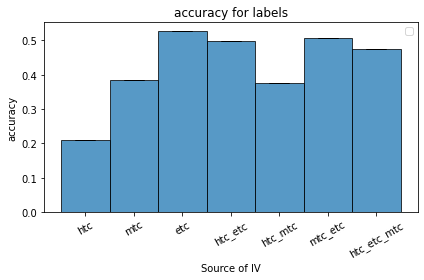

Row index 0
IV: ['human_top_confidence'] 
DV: ['labels']
Metrics
	accuracy: 0.2113
		 'human_top_confidence' sensitivity: 0.0112
	recall: 0.3043
		 'human_top_confidence' sensitivity: 0.0112
	recall_per_class: [0.25581395 0.60869565 0.0483871 ]
	f1: 0.1984
		 'human_top_confidence' sensitivity: 0.0054
	f1_per_class: [0.18965517 0.31460674 0.09090909]
Row index 1
IV: ['model_top_confidence'] 
DV: ['labels']
Metrics
	accuracy: 0.3850
		 'model_top_confidence' sensitivity: 0.0510
	recall: 0.3359
		 'model_top_confidence' sensitivity: 0.0510
	recall_per_class: [0.48837209 0.04347826 0.47580645]
	f1: 0.2945
		 'model_top_confidence' sensitivity: 0.0430
	f1_per_class: [0.29787234 0.07272727 0.51304348]
Row index 2
IV: ['explainer_top_confidence'] 
DV: ['labels']
Metrics
	accuracy: 0.5258
		 'explainer_top_confidence' sensitivity: 0.0780
	recall: 0.4018
		 'explainer_top_confidence' sensitivity: 0.0780
	recall_per_class: [0.44186047 0.02173913 0.74193548]
	f1: 0.3589
		 'explainer_top_confide

In [98]:
logreg_df_path = os.path.join(cur_group_save_dir, 'logreg_results', 'sensitivity.csv')
# logreg_df_path = 'saved/ADE20K/survey_results/group_1_3/logreg_results/sensitivity.csv'
logreg_df = pd.read_csv(logreg_df_path)
ivs = ['top_confidence']
dv = 'labels'
metrics = ['accuracy', 'recall', 'recall_per_class', 'f1', 'f1_per_class']
drop_correlated = True

cur_logreg_df = filter_df(logreg_df,
    ivs=ivs,
    dv=dv)

# Drop rows that have correlated variables
if drop_correlated:
    drop_idxs = []
    for idx, row in cur_logreg_df.iterrows():
        row_ivs = string_to_list(row['iv'], dtype='string')
        row_ivs = [word.replace("'", "") for word in row_ivs]
        
        # if len(row_ivs) > 2:
        #     drop_idxs.append(row['Unnamed: 0'])
        if len(row_ivs) == 2:
            var1, var2 = row_ivs
            if (var1, var2) in low_corr_set or (var2, var1) in low_corr_set:
                print("({}, {}) has low correlation".format(var1, var2))
            elif (var1, var2) in med_corr_set or (var2, var1) in med_corr_set:
                print("({}, {}) has moderate correlation".format(var1, var2))
            else:
                drop_idxs.append(row['Unnamed: 0'])
                print("Dropping ({}, {})".format(var1, var2))
    cur_logreg_df = cur_logreg_df.drop(drop_idxs, axis=0)

log_path = 'temp/temp.txt'
highest_acc_row = cur_logreg_df.loc[cur_logreg_df['accuracy'].idxmax()]
print("Highest accuracy with {}: {:.4f}".format(
    highest_acc_row['iv'],
    highest_acc_row['accuracy']))

plot_metric_v_inputs(
    df=cur_logreg_df,
    ivs=ivs,
    dv=dv,
    graph_metric='accuracy')
print_summary(
    df=cur_logreg_df,
    metrics=metrics,
    log_path=log_path)

#### Show Confusion Matrix of one of the classifiers

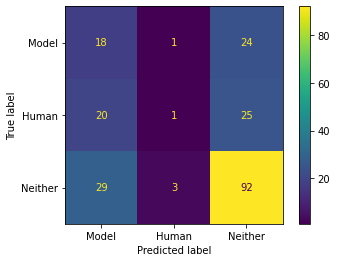

In [105]:
logreg_restore_dir = 'saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/group_csvs/group_2_4_5/logreg_results'
clfs_path = os.path.join(logreg_restore_dir, 'clfs.pth')
clfs = torch.load(clfs_path)

clf_idx = 2 # 2 is using explainer top confidence
x_names = ['explainer_top_confidence']
clf = clfs[clf_idx]
val_X = val_rows[x_names]
val_y = val_rows[y_names]
unique_labels = [0, 1, 2]
predictions = clf.predict(val_X)

cmat = sklearn.metrics.confusion_matrix(
        val_y,
        predictions,
        labels=unique_labels)

cmat_display = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=cmat,
    display_labels=['Model', 'Human', 'Neither'])
cmat_display.plot()
plt.show()

## Visualization of Images in Each Breakdown

#### Setup

In [45]:

cifar_data_path = 'data/cifar10-processed/cifar10_image_labels.pth'
cifar_data = torch.load(cifar_data_path)
cifar_test_images = cifar_data['test']['images'] / 255.0
cifar_test_labels = cifar_data['test']['predictions']
group_csvs_dir = 'saved/cifar10/resnet18/explainer/pixels/model_soft_labels/hparam_search/cross_entropy/0627_150603/trials/lr_0.001-wd_0.1/analysis/group_csvs'
group_names = ['group_{}'.format(i) for i in range(1, 6)]

image_save_dir = os.path.join(os.path.dirname(group_csvs_dir), 'visualizations')
ensure_dir(image_save_dir)

dfs = []
idxs = []
for group_name in group_names:
    csv_path = os.path.join(group_csvs_dir, '{}.csv'.format(group_name))
    df = pd.read_csv(csv_path)
    dfs.append(df)
    idxs.append(df['image_idxs'])


#### Display

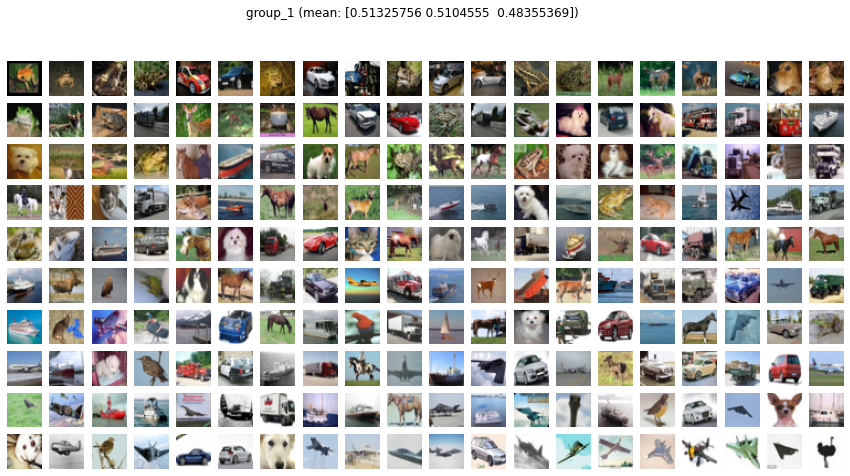

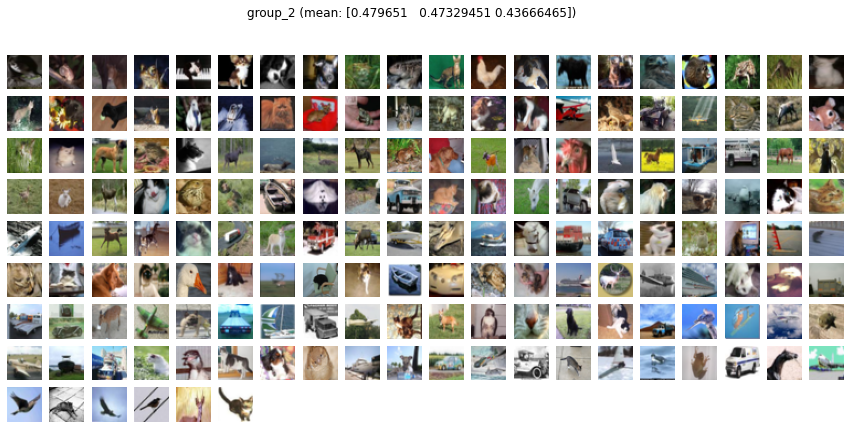

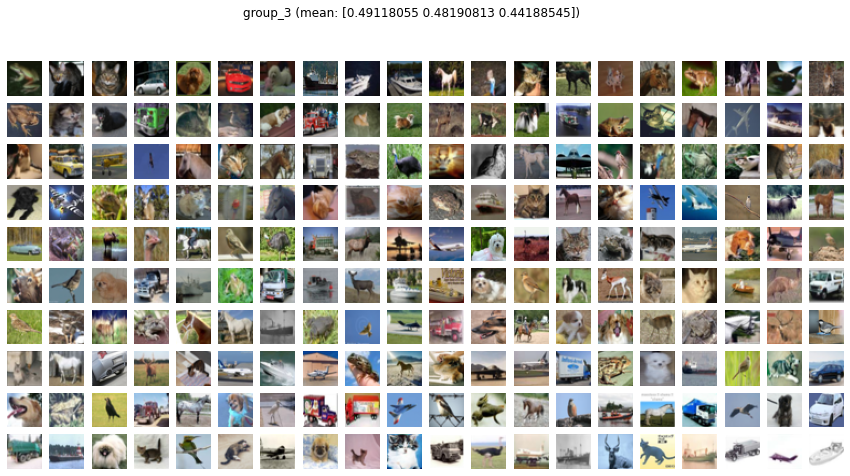

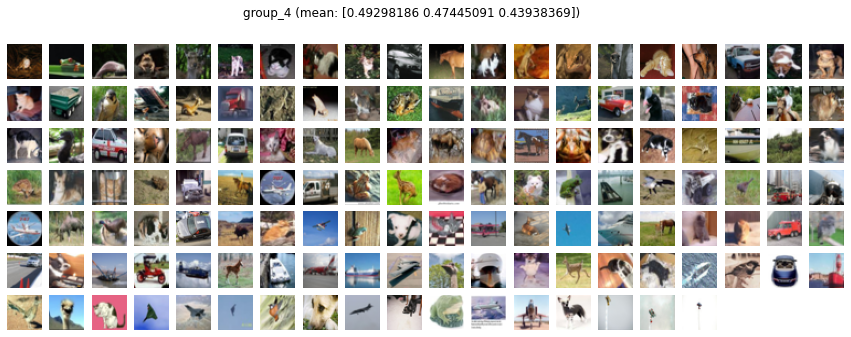

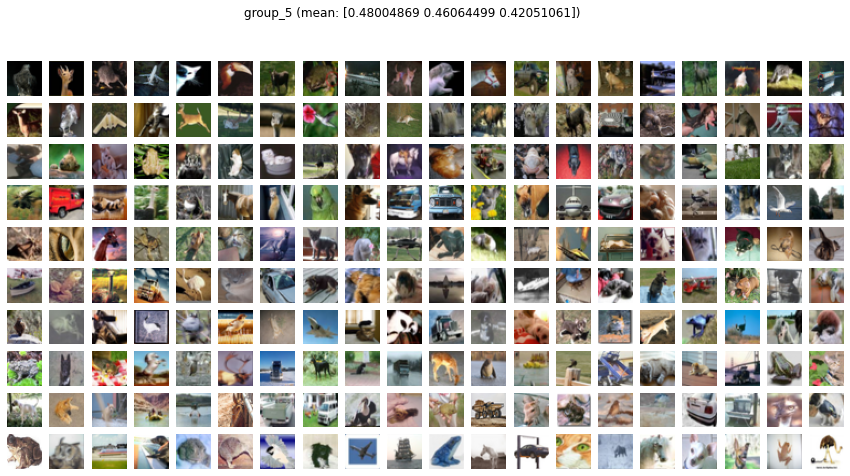

In [65]:
seed = 0
max_images = 200
images_per_row = 20
display_size = (0.75, 0.75)
def display_images(dfs,
                   group_names,
                   idxs,
                   images_array,
                   image_save_dir=None):
    for df, group_name, image_idxs in zip(dfs, group_names, idxs):
        n_samples = min(len(df), max_images)
        # Randomly select max_images rows
        df = df.sample(n=n_samples, random_state=seed)
        image_idxs = df['image_idxs'].values

        images = images_array[image_idxs, ...]
        # Sort images by increasing average pixel intensity
        mean_pixel_val = np.mean(images, axis=(1, 2, 3))
        mean_per_channel = np.mean(images, axis=(0, 1, 2))
        sort_idxs = np.argsort(mean_pixel_val)
        images = images[sort_idxs, ...]
        images = make_grid(
            flattened=images,
            items_per_row=images_per_row)
        
        if image_save_dir is not None:
            visualization_save_path = os.path.join(image_save_dir, '{}_{}_samples.pdf'.format(group_name, len(images)))
        else:
            visualization_save_path = None
        show_image_rows(
            images=images,
            figure_title='{} (mean: {})'.format(group_name, mean_per_channel),
            image_size=display_size,
            save_path=visualization_save_path)
        
display_images(
    dfs=dfs,
    group_names=group_names,
    idxs=idxs,
    images_array=cifar_test_images,
    image_save_dir=image_save_dir)


#### Calculate mean pixel values and if any differences are statistically significant

In [48]:
import scipy.stats as stats
seed = 0
print_only_significant = True
significance_threshold = 0.05

# Calculate mean pixel values for entirety of groups
for group_name, image_idxs in zip(group_names, idxs):
    images = cifar_test_images[image_idxs]
    mean_pixels = np.mean(images, axis=(0, 1, 2))
    std_pixels = np.std(images, axis=(0, 1, 2))
    print("Mean pixel values for {}: {} ({})".format(group_name, mean_pixels, std_pixels))

# Statistical Tests of Significance
print("\nStatistical Significance Tests Across Groups")
if print_only_significant:
    print("Only printing groups with significant differences")
    
for i in range(0, len(idxs) - 1):
    for j in range(i+1, len(idxs)):
        idxs_i = idxs[i]
        idxs_j = idxs[j]
        images_i = cifar_test_images[idxs_i]
        images_j = cifar_test_images[idxs_j]
        
        mean_pixels_i = np.mean(images_i, axis=(1, 2)) # N x 3
        mean_pixels_j = np.mean(images_j, axis=(1, 2)) 
        
        ttest = stats.ttest_ind(
            a=mean_pixels_i,
            b=mean_pixels_j,
            axis=0,
            equal_var=True,
            random_state=seed)
        print("Groups {} and {}:".format(i+1, j+1))
        for stat, pval, color in zip(ttest.statistic, ttest.pvalue, ["Red", "Green", "Blue"]):
            if not print_only_significant or pval < significance_threshold:
                print("\t{}: {:.4f} (p={:.4f})".format(color, stat, pval))
        

Mean pixel values for group_1: [0.49833748 0.49505262 0.46571268] ([0.24588074 0.24480197 0.26750021])
Mean pixel values for group_2: [0.479651   0.47329451 0.43666465] ([0.24429389 0.2425114  0.26051821])
Mean pixel values for group_3: [0.4920487  0.47961459 0.44101831] ([0.24689878 0.24122813 0.25711439])
Mean pixel values for group_4: [0.49298186 0.47445091 0.43938369] ([0.2490837  0.24222911 0.26149525])
Mean pixel values for group_5: [0.4886485  0.4688648  0.43318046] ([0.25036436 0.2427151  0.25434829])

Statistical Significance Tests Across Groups
Only printing groups with significant differences
Groups 1 and 2:
	Green: 2.1915 (p=0.0285)
	Blue: 2.2874 (p=0.0222)
Groups 1 and 3:
	Red: 2.3465 (p=0.0190)
	Green: 5.9060 (p=0.0000)
	Blue: 7.6939 (p=0.0000)
Groups 1 and 4:
Groups 1 and 5:
	Green: 3.9994 (p=0.0001)
	Blue: 3.9265 (p=0.0001)
Groups 2 and 3:
Groups 2 and 4:
Groups 2 and 5:
Groups 3 and 4:
Groups 3 and 5:
Groups 4 and 5:


In [63]:
# Calculate mean pixel intensity of each group
seed = 0
print_only_significant = True
significance_threshold = 0.05
mean_intensity = []
# Calculate mean intensity for entirety of groups
for group_name, image_idxs in zip(group_names, idxs):
    images = cifar_test_images[image_idxs]
    group_mean_intensity = np.mean(images, axis=(1, 2, 3))
    mean_intensity.append(group_mean_intensity)
    print("Mean pixel values for {}: {:.3f} ({:.3f})".format(group_name, np.mean(group_mean_intensity), np.std(group_mean_intensity)))

# Statistical Tests of Significance
print("\nStatistical Significance Tests Across Groups")
if print_only_significant:
    print("Only printing groups with significant differences")
    
for i in range(0, len(mean_intensity) - 1):
    for j in range(i+1, len(mean_intensity)):
        mean_intensity_i = mean_intensity[i]
        mean_intensity_j = mean_intensity[j]
        
        ttest = stats.ttest_ind(
            a=mean_intensity_i,
            b=mean_intensity_j,
            equal_var=True,
            random_state=seed)
        print("Groups {} and {}:".format(i+1, j+1))
        if not print_only_significant or ttest.pvalue < significance_threshold:
            print(" {:.4f} (p={:.4f})".format(ttest.statistic, ttest.pvalue))
        else:
            print("")
        

Mean pixel values for group_1: 0.486 (0.126)
Mean pixel values for group_2: 0.463 (0.116)
Mean pixel values for group_3: 0.471 (0.123)
Mean pixel values for group_4: 0.469 (0.134)
Mean pixel values for group_5: 0.464 (0.126)

Statistical Significance Tests Across Groups
Only printing groups with significant differences
Groups 1 and 2:
 2.3226 (p=0.0203)
Groups 1 and 3:
 5.9299 (p=0.0000)
Groups 1 and 4:

Groups 1 and 5:
 3.4658 (p=0.0005)
Groups 2 and 3:

Groups 2 and 4:

Groups 2 and 5:

Groups 3 and 4:

Groups 3 and 5:

Groups 4 and 5:



#### Calculate entropy of images and average across groups
1. Shannon entropy of RGB channels then average them
2. Shannon entropy of pixel intensities

In [24]:
from skimage.measure import shannon_entropy

##### RGB Entropy

In [49]:
# Calculate Shannon entropy of each RGB channel separately
shannon_rgb_entropies = []
colors = ["Red", "Green", "Blue"]
color_channel = 3

for group_name, image_idxs in zip(group_names, idxs):
    images = cifar_test_images[image_idxs]
    assert images.shape[color_channel] == 3, "Color channel {} has {} dimensions. Expected 3.".format(color_channel, images.shape[color_channel])
    entropies = []
    for color_idx, color_name in enumerate(colors):
        if color_channel == 3:
            images_channel = images[:, :, :, color_idx]
        else:
            raise ValueError("Color channel {} not supported".format(color_channel))
        entropies_channel = []
        for image_channel in images_channel:
            entropies_channel.append(shannon_entropy(image_channel))
        entropies.append(entropies_channel)
    entropies = np.array(entropies)
    entropies = np.transpose(entropies, axes=(1, 0))
    
    shannon_rgb_entropies.append(np.array(entropies))
    print("Entropies for {} (Mean, STD)".format(group_name))
    print("Mean:")
    for color, entropy in zip(colors, entropies):
        mean_entropy = np.mean(entropy)
        print("{:.3f}, ".format(mean_entropy), end="")
    print("")
    for color, entropy in zip(colors, entropies):
        std_entropy = np.std(entropy)
        print("{:.3f}, ".format(std_entropy), end="")
    print("")
            

        
        

Entropies for group_1 (Mean, STD)
Mean:
7.605, 6.906, 6.954, 
0.020, 0.084, 0.158, 
Entropies for group_2 (Mean, STD)
Mean:
7.537, 7.355, 6.867, 
0.000, 0.057, 0.176, 
Entropies for group_3 (Mean, STD)
Mean:
7.154, 7.106, 7.168, 
0.232, 0.044, 0.142, 
Entropies for group_4 (Mean, STD)
Mean:
7.142, 7.539, 6.965, 
0.207, 0.009, 0.189, 
Entropies for group_5 (Mean, STD)
Mean:
6.702, 6.333, 6.998, 
0.079, 0.254, 0.066, 


In [61]:
# Calculate statistical significance of RGB entropies across groups
seed = 0
print_only_significant = False
significance_threshold = 0.05

for i in range(0, len(shannon_rgb_entropies) - 1):
    for j in range(i+1, len(shannon_rgb_entropies)):
        entropies_i = shannon_rgb_entropies[i]
        entropies_j = shannon_rgb_entropies[j]
        ttest = stats.ttest_ind(
            a=entropies_i,
            b=entropies_j,
            axis=0,
            equal_var=True,
            random_state=seed)
        print("Groups {} and {}:".format(i+1, j+1))
        for stat, pval, color in zip(ttest.statistic, ttest.pvalue, ["Red", "Green", "Blue"]):
            if not print_only_significant or pval < significance_threshold:
                print("\t{}: {:.4f} (p={:.4f})".format(color, stat, pval))

Groups 1 and 2:
	Red: -0.5176 (p=0.6048)
	Green: -0.6567 (p=0.5114)
	Blue: -0.8207 (p=0.4119)
Groups 1 and 3:
	Red: 0.8014 (p=0.4229)
	Green: 0.7949 (p=0.4267)
	Blue: -1.0605 (p=0.2890)
Groups 1 and 4:
	Red: 0.3854 (p=0.6999)
	Green: 0.6411 (p=0.5215)
	Blue: 1.1773 (p=0.2391)
Groups 1 and 5:
	Red: -0.8943 (p=0.3712)
	Green: -1.1438 (p=0.2528)
	Blue: -1.9757 (p=0.0482)
Groups 2 and 3:
	Red: 0.7623 (p=0.4459)
	Green: 0.9169 (p=0.3593)
	Blue: 0.6124 (p=0.5403)
Groups 2 and 4:
	Red: 0.6159 (p=0.5384)
	Green: 0.9109 (p=0.3631)
	Blue: 1.4396 (p=0.1510)
Groups 2 and 5:
	Red: -0.0673 (p=0.9464)
	Green: -0.0926 (p=0.9263)
	Blue: -0.4916 (p=0.6232)
Groups 3 and 4:
	Red: 0.2094 (p=0.8341)
	Green: 0.4875 (p=0.6259)
	Blue: 1.5716 (p=0.1161)
Groups 3 and 5:
	Red: -1.2783 (p=0.2012)
	Green: -1.5557 (p=0.1198)
	Blue: -1.7378 (p=0.0823)
Groups 4 and 5:
	Red: -0.8085 (p=0.4192)
	Green: -1.1840 (p=0.2369)
	Blue: -2.1752 (p=0.0300)


##### Pixel Intensity Entropy

In [60]:
# Calculate Shannon entropy of pixel intensities
shannon_entropies = []
color_channel = 3
print_only_significant = False
significance_threshold = 0.05

for group_name, image_idxs in zip(group_names, idxs):
    images = cifar_test_images[image_idxs]
    entropies = []
    grayscale_images = np.mean(images, axis=color_channel)
    
    for grayscale_image in grayscale_images:
        entropies.append(shannon_entropy(grayscale_image))
    
    shannon_entropies.append(np.array(entropies))
    print("Mean entropy for group {}: {:.3f} ({:.3f})".format(group_name, np.mean(entropies), np.std(entropies)))
    
            
# Calculate statistical significance tests
print("Statistical Significance Tests")
for i in range(0, len(shannon_entropies) - 1):
    for j in range(i+1, len(shannon_entropies)):
        entropies_i = shannon_entropies[i]
        entropies_j = shannon_entropies[j]
        ttest = stats.ttest_ind(
            a=entropies_i,
            b=entropies_j,
            equal_var=True,
            random_state=seed)
        print("Groups {} and {}:".format(i+1, j+1), end="")
        if not print_only_significant or ttest.pvalue < significance_threshold:
            print(" {:.4f} (p={:.4f})".format(ttest.statistic, ttest.pvalue))
        else:
            print("")
       

Mean entropy for group group_1: 8.422 (0.677)
Mean entropy for group group_2: 8.436 (0.531)
Mean entropy for group group_3: 8.425 (0.635)
Mean entropy for group group_4: 8.414 (0.835)
Mean entropy for group group_5: 8.491 (0.585)
Statistical Significance Tests
Groups 1 and 2: -0.2701 (p=0.7871)
Groups 1 and 3: -0.2193 (p=0.8264)
Groups 1 and 4: 0.1352 (p=0.8924)
Groups 1 and 5: -1.9699 (p=0.0489)
Groups 2 and 3: 0.2281 (p=0.8196)
Groups 2 and 4: 0.2821 (p=0.7781)
Groups 2 and 5: -1.0317 (p=0.3027)
Groups 3 and 4: 0.1988 (p=0.8424)
Groups 3 and 5: -2.0182 (p=0.0436)
Groups 4 and 5: -1.1784 (p=0.2392)


### Inspect the explainer's second predictions in cases of misalignment
1. If model != human and explainer = model (group 2), what % of samples if the explainer's second choice = human prediction?
2. If model = human but explainer = neither (group 3), what is the distribution of rank of model/human's top predictions?
3. If model != human and explainer = human (group 4), what % of samples is the explainer's second choice = model prediction?
4. If model != human and explainer = neither (group 5), what is the distribution of rank of model's top prediction? Of human's top prediction?


#### Function Definitions

In [118]:
def get_prediction_rank(probabilities, predictions):
    '''
    Given predictions and probabilities for N samples, return the rank (0-indexed) of the predictions
    
    Arg(s):
        probabilities : N x C np.array
        predictions : N np.array
    Returns:
        N np.array
    '''
    # Get indices to sort probabilities in decreasing order
    sort_idxs = np.argsort(-probabilities)  # N x C array
    n_classes = sort_idxs.shape[1]
    # Expand predictions to match sort_idxs shape
    repeated_predictions = [predictions for i in range(n_classes)]
    repeated_predictions = np.stack(repeated_predictions, axis=1)
    
    # One hot encode the index where the class corresponds to the prediction
    rank_one_hot = np.where(sort_idxs == repeated_predictions, 1, 0)
    # Rank is 0 for higher probability
    rank = np.argsort(rank_one_hot, axis=1)[:, -1]
    return rank

#### Experimental Code

In [80]:
# Collect the logits for each agent and each group
human_probabilities = [] # hold array of logits for each group
model_probabilities = []
explainer_probabilities = []

agents = ['human', 'model', 'explainer']
for df in dfs:
    # Convert string arrays to numpy arrays
    df = convert_string_columns(
        df=df,
        columns=['{}_probabilities'.format(agent) for agent in agents])
    
    cur_human_probabilities = np.stack(df['human_probabilities'].to_numpy(), axis=0)
    assert len(cur_human_probabilities.shape) == 2
    human_probabilities.append(cur_human_probabilities)
    
    cur_model_probabilities = np.stack(df['model_probabilities'].to_numpy(), axis=0)
    assert len(cur_model_probabilities.shape) == 2
    model_probabilities.append(cur_model_probabilities)
    
    cur_explainer_probabilities = np.stack(df['explainer_probabilities'].to_numpy(), axis=0)
    assert len(cur_explainer_probabilities.shape) == 2
    explainer_probabilities.append(cur_explainer_probabilities)
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Proportion of samples where human prediction is explainer's second most likely: 0.3434
Mean rank of human predictions: 3.247 (2.366)
Proportion of human predictions are explainer's second prediction: 0.3434


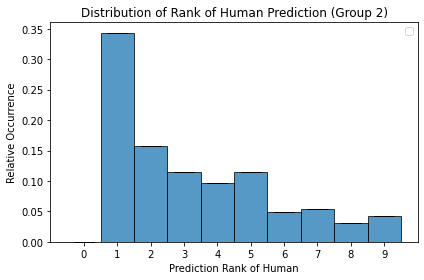

<Axes: title={'center': 'Distribution of Rank of Human Prediction (Group 2)'}, xlabel='Prediction Rank of Human', ylabel='Relative Occurrence'>

In [132]:
# 1. If model != human and explainer = model (group 2), what % of samples if the explainer's second choice = human prediction?
cur_idx = 1 # group 2
cur_human_probabilities = human_probabilities[cur_idx]
cur_model_probabilities = model_probabilities[cur_idx]
cur_explainer_probabilities = explainer_probabilities[cur_idx]

# Assert group 2 invariances
assert (np.argmax(cur_model_probabilities, axis=1) == np.argmax(cur_explainer_probabilities, axis=1)).all()
assert (np.argmax(cur_human_probabilities, axis=1) != np.argmax(cur_model_probabilities, axis=1)).all()

cur_human_predictions = np.argmax(cur_human_probabilities, axis=1)
sort_idxs = np.argsort(cur_explainer_probabilities, axis=1)
explainer_second_predictions = sort_idxs[:, -2]
assert explainer_second_predictions.shape == cur_human_predictions.shape

overlap = np.count_nonzero(explainer_second_predictions == cur_human_predictions) / len(cur_human_predictions)
print("Proportion of samples where human prediction is explainer's second most likely: {:.4f}".format(overlap))

human_prediction_rank = get_prediction_rank(cur_explainer_probabilities, cur_human_predictions)
print("Mean rank of human predictions: {:.3f} ({:.3f})".format(np.mean(human_prediction_rank), np.std(human_prediction_rank)))
print("Proportion of human predictions are explainer's second prediction: {:.4f}".format(
    np.count_nonzero(human_prediction_rank == 1) / len(human_prediction_rank)))

# Create a bar graph
bincount = np.bincount(human_prediction_rank) / len(human_prediction_rank)
bin_labels = [i for i in range(10)]
bar_graph(
    data=[bincount],
    labels=bin_labels,
    xlabel='Prediction Rank of Human',
    ylabel='Relative Occurrence',
    title='Distribution of Rank of Human Prediction (Group 2)')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mean rank of human/model predictions: 3.074 (2.243) 
Proportion of human/model predictions are explainer's second prediction: 0.3319


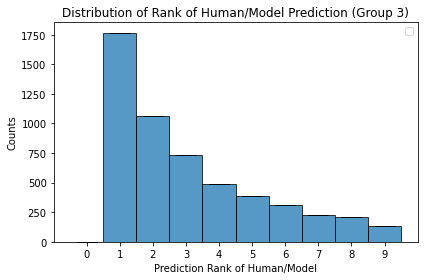

<Axes: title={'center': 'Distribution of Rank of Human/Model Prediction (Group 3)'}, xlabel='Prediction Rank of Human/Model', ylabel='Counts'>

In [133]:
# 2. If model = human but explainer = neither (group 3), what is the distribution of rank of model/human's top predictions?
cur_idx = 2 # group 3
cur_human_probabilities = human_probabilities[cur_idx]
cur_model_probabilities = model_probabilities[cur_idx]
cur_explainer_probabilities = explainer_probabilities[cur_idx]

# Assert group 3 invariances
assert (np.argmax(cur_model_probabilities, axis=1) == np.argmax(cur_human_probabilities, axis=1)).all()
assert (np.argmax(cur_human_probabilities, axis=1) != np.argmax(cur_explainer_probabilities, axis=1)).all()
assert (np.argmax(cur_model_probabilities, axis=1) != np.argmax(cur_explainer_probabilities, axis=1)).all()

cur_human_predictions = np.argmax(cur_human_probabilities, axis=1)

human_prediction_rank = get_prediction_rank(cur_explainer_probabilities, cur_human_predictions)
print("Mean rank of human/model predictions: {:.3f} ({:.3f}) ".format(np.mean(human_prediction_rank), np.std(human_prediction_rank)))
print("Proportion of human/model predictions are explainer's second prediction: {:.4f}".format(
    np.count_nonzero(human_prediction_rank == 1) / len(human_prediction_rank)))

# Create a bar graph
bincount = np.bincount(human_prediction_rank)
bin_labels = [i for i in range(10)]
bar_graph(
    data=[bincount],
    labels=bin_labels,
    xlabel='Prediction Rank of Human/Model',
    ylabel='Counts',
    title='Distribution of Rank of Human/Model Prediction (Group 3)')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Proportion of samples where model prediction is explainer's second most likely: 0.3577
Mean rank of model predictions: 3.036 (2.206)
Proportion of model predictions are explainer's second prediction: 0.3577


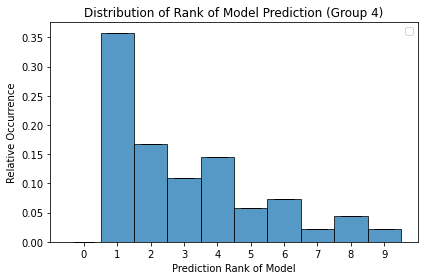

<Axes: title={'center': 'Distribution of Rank of Model Prediction (Group 4)'}, xlabel='Prediction Rank of Model', ylabel='Relative Occurrence'>

In [135]:
# 3. If model != human and explainer = human (group 4), what % of samples is the explainer's second choice = model prediction?
cur_idx = 3 # group 4
cur_human_probabilities = human_probabilities[cur_idx]
cur_model_probabilities = model_probabilities[cur_idx]
cur_explainer_probabilities = explainer_probabilities[cur_idx]

# Assert group 4 invariances
assert (np.argmax(cur_human_probabilities, axis=1) == np.argmax(cur_explainer_probabilities, axis=1)).all()
assert (np.argmax(cur_human_probabilities, axis=1) != np.argmax(cur_model_probabilities, axis=1)).all()

cur_model_predictions = np.argmax(cur_model_probabilities, axis=1)
sort_idxs = np.argsort(cur_explainer_probabilities, axis=1)
explainer_second_predictions = sort_idxs[:, -2]
assert explainer_second_predictions.shape == cur_model_predictions.shape

overlap = np.count_nonzero(explainer_second_predictions == cur_model_predictions) / len(cur_model_predictions)
print("Proportion of samples where model prediction is explainer's second most likely: {:.4f}".format(overlap))

model_prediction_rank = get_prediction_rank(cur_explainer_probabilities, cur_model_predictions)
print("Mean rank of model predictions: {:.3f} ({:.3f})".format(np.mean(model_prediction_rank), np.std(model_prediction_rank)))
print("Proportion of model predictions are explainer's second prediction: {:.4f}".format(
    np.count_nonzero(model_prediction_rank == 1) / len(model_prediction_rank)))

# Create a bar graph
bincount = np.bincount(model_prediction_rank) / len(model_prediction_rank)
bin_labels = [i for i in range(10)]
bar_graph(
    data=[bincount],
    labels=bin_labels,
    xlabel='Prediction Rank of Model',
    ylabel='Relative Occurrence',
    title='Distribution of Rank of Model Prediction (Group 4)')

Mean rank of human predictions: 4.360 (2.557)
Proportion of human predictions are explainer's second prediction: 0.1650
Mean rank of model predictions: 3.825 (2.372)
Proportion of model predictions are explainer's second prediction: 0.1995


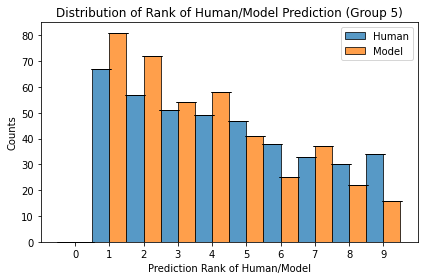

<Axes: title={'center': 'Distribution of Rank of Human/Model Prediction (Group 5)'}, xlabel='Prediction Rank of Human/Model', ylabel='Counts'>

In [136]:
#4. If model != human and explainer = neither (group 5), what is the distribution of rank of model's top prediction? Of human's top prediction?
cur_idx = 4 # group 5
cur_human_probabilities = human_probabilities[cur_idx]
cur_model_probabilities = model_probabilities[cur_idx]
cur_explainer_probabilities = explainer_probabilities[cur_idx]

# Assert group 5 invariances
assert (np.argmax(cur_model_probabilities, axis=1) != np.argmax(cur_explainer_probabilities, axis=1)).all()
assert (np.argmax(cur_human_probabilities, axis=1) != np.argmax(cur_model_probabilities, axis=1)).all()
assert (np.argmax(cur_human_probabilities, axis=1) != np.argmax(cur_explainer_probabilities, axis=1)).all()

cur_human_predictions = np.argmax(cur_human_probabilities, axis=1)
cur_model_predictions = np.argmax(cur_model_probabilities, axis=1)

human_prediction_rank = get_prediction_rank(cur_explainer_probabilities, cur_human_predictions)
print("Mean rank of human predictions: {:.3f} ({:.3f})".format(np.mean(human_prediction_rank), np.std(human_prediction_rank)))
print("Proportion of human predictions are explainer's second prediction: {:.4f}".format(
    np.count_nonzero(human_prediction_rank == 1) / len(human_prediction_rank)))

model_prediction_rank = get_prediction_rank(cur_explainer_probabilities, cur_model_predictions)
print("Mean rank of model predictions: {:.3f} ({:.3f})".format(np.mean(model_prediction_rank), np.std(model_prediction_rank)))
print("Proportion of model predictions are explainer's second prediction: {:.4f}".format(
    np.count_nonzero(model_prediction_rank == 1) / len(model_prediction_rank)))      

# Create a bar graph
human_bincount = np.bincount(human_prediction_rank) #/ len(human_prediction_rank)
model_bincount = np.bincount(model_prediction_rank) #/ len(model_prediction_rank)
bin_labels = [i for i in range(10)]
bar_graph(
    data=[human_bincount, model_bincount],
    groups=['Human', 'Model'],
    labels=bin_labels,
    xlabel='Prediction Rank of Human/Model',
    ylabel='Counts',
    title='Distribution of Rank of Human/Model Prediction (Group 5)')

#### Get class distributions for ground truth, human, model, and explainer

In [ ]:
n_classes = 10
class_list_path = 'data/cifar10-processed/classes.txt'
class_list = read_lists(class_list_path)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


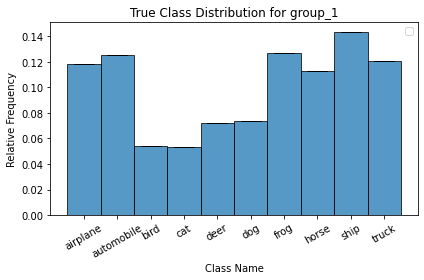

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


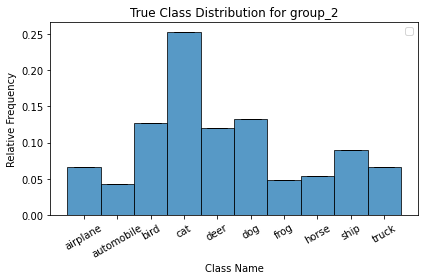

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


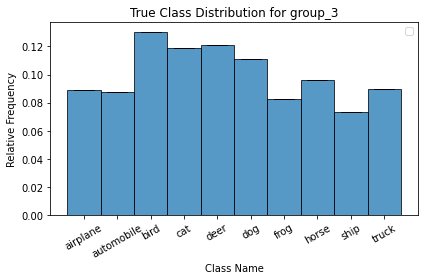

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


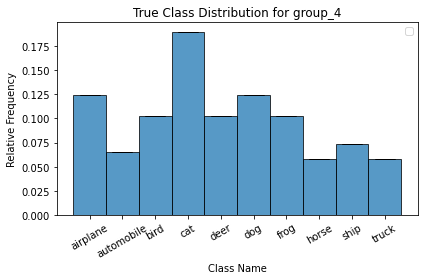

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


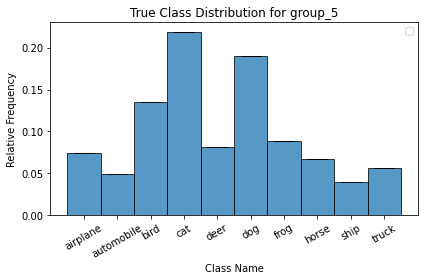

In [21]:
# What is the class distribution for each group?
save_path_template = os.path.join(image_save_dir, 'true_class_dist', '{}_true_class_distribution.png')
ensure_dir(os.path.dirname(save_path_template))

for image_idxs, group_name in zip(idxs, group_names):
    ground_truth_labels = cifar_test_labels[image_idxs]
    # print(ground_truth_labels.shape)
    unique, count = np.unique(ground_truth_labels, return_counts=True)
    assert len(unique) == n_classes, "Mismatch number of classes. Expected {} but received {}.".format(n_classes, len(unique))
    count = count / np.sum(count)
    save_path = save_path_template.format(group_name)
    bar_graph(
        data=[count],
        labels=class_list,
        xlabel='Class Name',
        ylabel='Relative Frequency',
        xlabel_rotation=30,
        title='True Class Distribution for {}'.format(group_name),
        save_path=save_path)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


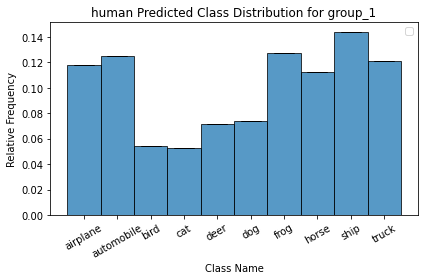

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


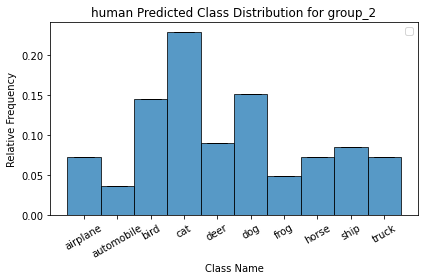

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


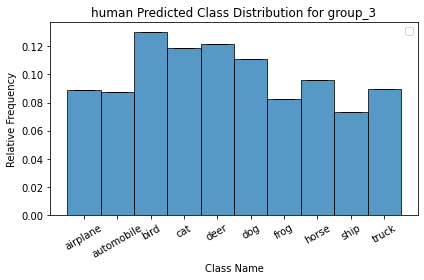

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


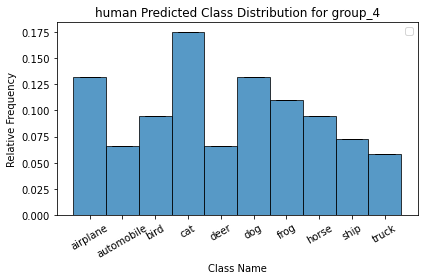

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


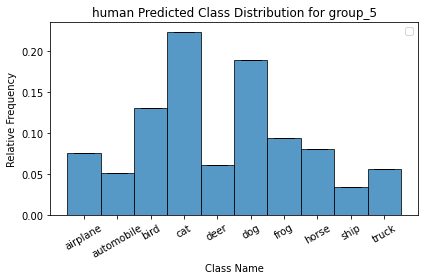

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


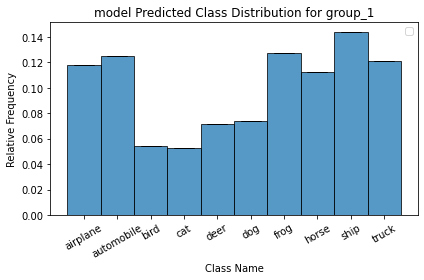

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


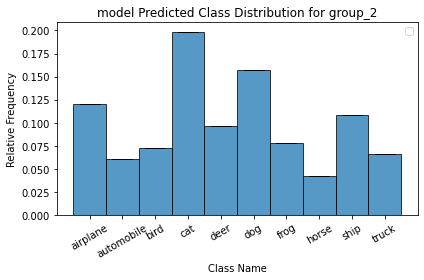

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


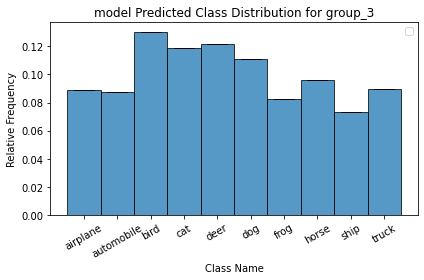

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


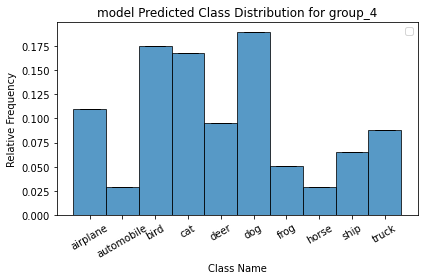

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


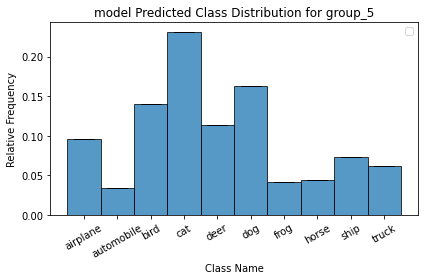

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


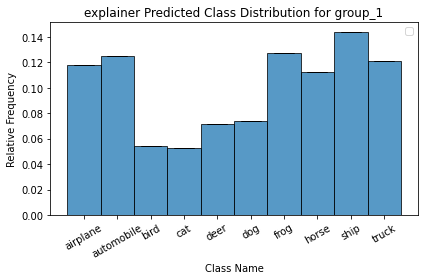

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


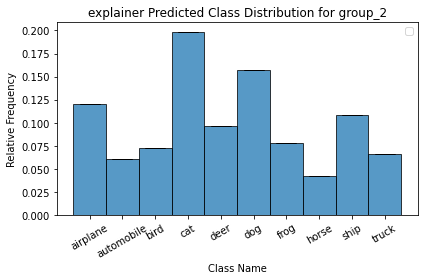

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


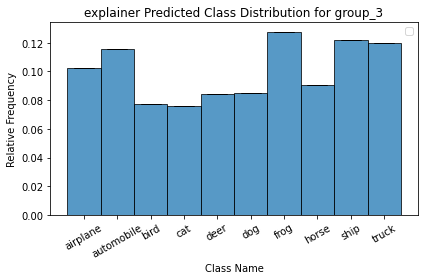

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


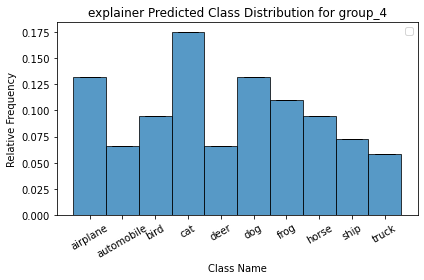

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


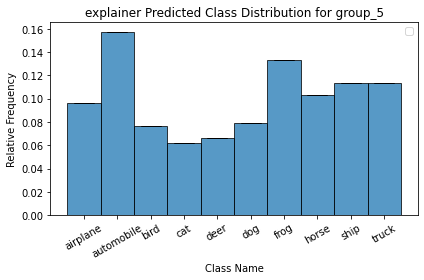

In [27]:
agents = ['human', 'model', 'explainer']

for agent in agents:
    cur_save_dir = os.path.join(image_save_dir, '{}_class_dist'.format(agent))
    ensure_dir(cur_save_dir)
    
    for df, group_name in zip(dfs, group_names):
        predictions = df['{}_predictions'.format(agent)].values
        # print(predictions.shape)
        unique, count = np.unique(predictions, return_counts=True)
        assert len(unique) == n_classes, "Mismatch number of classes. Expected {} but received {}.".format(n_classes, len(unique))
        count = count / np.sum(count)
        save_path = os.path.join(cur_save_dir, '{}_{}_dist.png'.format(group_name, agent))
                   
        bar_graph(
            data=[count],
            labels=class_list,
            xlabel='Class Name',
            ylabel='Relative Frequency',
            xlabel_rotation=30,
            title='{} Predicted Class Distribution for {}'.format(agent, group_name),
            save_path=save_path)